# Conditional Average Treatment Effects (CATE) with DoWhy and EconML

This is an experimental feature where we use [EconML](https://github.com/microsoft/econml) methods from DoWhy. Using EconML allows CATE estimation using different methods. 

All four steps of causal inference in DoWhy remain the same: model, identify, estimate, and refute. The key difference is that we now call econml methods in the estimation step. There is also a simpler example using linear regression to understand the intuition behind CATE estimators. 

All datasets are generated using linear structural equations.



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import logging

import dowhy
from dowhy import CausalModel
import dowhy.datasets

import econml
import warnings
warnings.filterwarnings('ignore')

BETA = 10

In [3]:
data = dowhy.datasets.linear_dataset(BETA, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                     num_treatments=1,
                                    treatment_is_binary=False,
                                    num_discrete_common_causes=2,
                                    num_discrete_effect_modifiers=0,
                                    one_hot_encode=False)
df=data['df']
print(df.head())
print("True causal estimate is", data["ate"])

         X0        X1   Z0        Z1        W0        W1 W2 W3         v0  \
0 -1.291902  0.344282  1.0  0.888152  1.270022 -0.839051  1  3  29.859951   
1 -1.101423  0.809118  1.0  0.851631 -0.564214  1.412823  0  0  19.672266   
2 -1.053010  1.266275  0.0  0.696014 -1.434985  0.548982  2  2  14.598053   
3 -1.312536  0.885405  0.0  0.074762  0.621044  0.157344  3  3  13.930344   
4 -0.223221 -0.864492  0.0  0.541058 -0.261892  2.516344  1  1  10.290366   

            y  
0  181.669352  
1  146.169316  
2  126.496269  
3  104.048223  
4   87.401358  
True causal estimate is 8.715261088847955


In [4]:
model = CausalModel(data=data["df"], 
                    treatment=data["treatment_name"], outcome=data["outcome_name"], 
                    graph=data["gml_graph"])

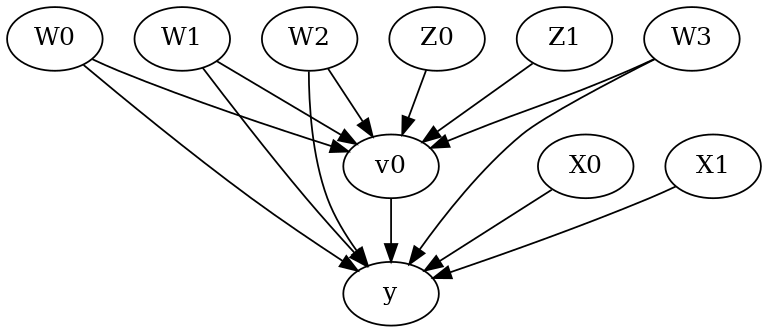

In [5]:
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [6]:
identified_estimand= model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W0,W3,W1,W2])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W3,W1,W2,U) = P(y|v0,W0,W3,W1,W2)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₁  Z₀]    ⎝d[Z₁  Z₀]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



## Linear Model 
First, let us build some intuition using a linear model for estimating CATE. The effect modifiers (that lead to a heterogeneous treatment effect) can be modeled as interaction terms with the treatment. Thus, their value modulates the effect of treatment. 

Below the estimated effect of changing treatment from 0 to 1. 

In [7]:
linear_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="backdoor.linear_regression",
                                       control_value=0,
                                       treatment_value=1)
print(linear_estimate) 

linear_regression


{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['X1', 'X0']}


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W0,W3,W1,W2])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W3,W1,W2,U) = P(y|v0,W0,W3,W1,W2)

## Realized estimand
b: y~v0+W0+W3+W1+W2+v0*X1+v0*X0
Target units: ate

## Estimate
Mean value: 8.715223359305316
### Conditional Estimates
__categorical__X1              __categorical__X0           
(-3.3129999999999997, -0.192]  (-5.058000000000001, -1.494]     1.289949
                               (-1.494, -0.906]                 4.631148
                               (-0.906, -0.386]                 6.571286
                               (-0.386, 0.195]                  8.387364
                               (0.195, 3.409]                  11.398820
(-0.192, 0.402]                (-5.058000000000001, -1.494]     2.946513
                               (-1.49

## EconML methods
We now move to the more advanced methods from the EconML package for estimating CATE.

First, let us look at the double machine learning estimator. Method_name corresponds to the fully qualified name of the class that we want to use. For double ML, it is "econml.dml.DML". 

Target units defines the units over which the causal estimate is to be computed. This can be a lambda function filter on the original dataframe, a new Pandas dataframe, or a string corresponding to the three main kinds of target units ("ate", "att" and "atc"). Below we show an example of a lambda function. 

Method_params are passed directly to EconML. For details on allowed parameters, refer to the EconML documentation. 

In [8]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = lambda df: df["X0"]>1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=False)},
                                               "fit_params":{}})
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W0,W3,W1,W2])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W3,W1,W2,U) = P(y|v0,W0,W3,W1,W2)

## Realized estimand
b: y~v0+W0+W3+W1+W2 | X1,X0
Target units: Data subset defined by a function

## Estimate
Mean value: 16.114496688434464
Effect estimates: [14.04810157 17.70230993 17.49516854 16.68014755 16.62728797 17.03331195
 15.93682939 16.97497807 15.25295942 16.42402556 20.42240425 15.06706361
 15.63714484 17.75572203 19.38862427 12.31502434 15.29146111 16.43724292
 12.7059772  15.53924703 16.21968384 20.6364178  17.26338032 16.25295814
 15.27281044 18.13666223 17.43888069 15.49385588 15.50891703 17.08909858
 15.67530466 18.3356856  19.25652612 20.39835627 16.09440735 12.13527883
 16.74413104 11.78275378 13.58465809 17.43370198 14.46330668 14.89602228
 16.8

In [9]:
print("True causal estimate is", data["ate"])

True causal estimate is 8.715261088847955


In [10]:
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = 1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}})
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W0,W3,W1,W2])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W3,W1,W2,U) = P(y|v0,W0,W3,W1,W2)

## Realized estimand
b: y~v0+W0+W3+W1+W2 | X1,X0
Target units: 

## Estimate
Mean value: 8.677342736894095
Effect estimates: [ 5.85926366  7.29550023  8.2058959  ...  7.18108411 17.05968328
  7.69895233]



### CATE Object and Confidence Intervals
EconML provides its own methods to compute confidence intervals. Using BootstrapInference in the example below. 

In [11]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from econml.inference import BootstrapInference
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DML",
                                     target_units = "ate",
                                     confidence_intervals=True,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final": LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{
                                                               'inference': BootstrapInference(n_bootstrap_samples=100, n_jobs=-1),
                                                            }
                                              })
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W0,W3,W1,W2])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W3,W1,W2,U) = P(y|v0,W0,W3,W1,W2)

## Realized estimand
b: y~v0+W0+W3+W1+W2 | X1,X0
Target units: ate

## Estimate
Mean value: 8.691178381880352
Effect estimates: [ 5.88467968  7.32318974  8.23937043 ...  7.21020542 17.06807268
  7.73500811]
95.0% confidence interval: (array([ 5.87186147,  7.34887783,  8.27931524, ...,  7.23125122,
       17.20620624,  7.76397932]), array([ 5.97242274,  7.43617078,  8.39011532, ...,  7.31968415,
       17.50777842,  7.87291635]))



### Can provide a new inputs as target units and estimate CATE on them.

In [12]:
test_cols= data['effect_modifier_names'] # only need effect modifiers' values
test_arr = [np.random.uniform(0,1, 10) for _ in range(len(test_cols))] # all variables are sampled uniformly, sample of 10
test_df = pd.DataFrame(np.array(test_arr).transpose(), columns=test_cols)
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DML",
                                     target_units = test_df,
                                     confidence_intervals=False,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}
                                              })
print(dml_estimate.cate_estimates)

[11.75889313 11.74988869 14.73595553 14.43706669 14.17623044 12.08319328
 13.56227347 11.19884324 14.10075976 13.1235786 ]


### Can also retrieve the raw EconML estimator object for any further operations

In [13]:
print(dml_estimate._estimator_object)

## Works with any EconML method
In addition to double machine learning, below we example analyses using orthogonal forests, DRLearner (bug to fix), and neural network-based instrumental variables. 

### Binary treatment, Binary outcome

In [14]:
data_binary = dowhy.datasets.linear_dataset(BETA, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                    treatment_is_binary=True, outcome_is_binary=True)
# convert boolean values to {0,1} numeric
data_binary['df'].v0 = data_binary['df'].v0.astype(int)
data_binary['df'].y = data_binary['df'].y.astype(int)
print(data_binary['df'])

model_binary = CausalModel(data=data_binary["df"], 
                    treatment=data_binary["treatment_name"], outcome=data_binary["outcome_name"], 
                    graph=data_binary["gml_graph"])
identified_estimand_binary = model_binary.identify_effect(proceed_when_unidentifiable=True)

            X0        X1   Z0        Z1        W0        W1        W2  \
0    -0.441294  0.330750  0.0  0.708230 -1.412380  0.993430 -0.236550   
1     1.787636  0.171748  0.0  0.706278 -0.959771  2.794415  0.421839   
2    -0.987564 -1.113164  0.0  0.457331 -0.391646  0.420218  0.865400   
3     2.079224 -0.037009  1.0  0.844828 -1.200824  2.500319 -1.086728   
4     0.323884  1.014785  0.0  0.496706 -0.569862 -0.083822 -0.426115   
...        ...       ...  ...       ...       ...       ...       ...   
9995  1.761965 -0.270649  1.0  0.762931 -0.629004  0.770965 -0.698775   
9996  1.001227  2.267594  0.0  0.112357  0.747632  1.299106  2.095169   
9997 -0.140619  2.045580  0.0  0.202194 -1.261943  2.600799  1.217580   
9998  0.297996 -0.060648  0.0  0.906548  0.655622  1.935226 -0.555834   
9999  1.353070  1.372578  0.0  0.756436 -1.016362 -1.797038 -0.518223   

            W3  v0  y  
0     0.470949   1  1  
1     1.368702   1  1  
2    -0.047403   1  1  
3    -0.086794   1  1  
4  

#### Using DRLearner estimator

In [15]:
from sklearn.linear_model import LogisticRegressionCV
#todo needs binary y
drlearner_estimate = model_binary.estimate_effect(identified_estimand_binary, 
                                method_name="backdoor.econml.drlearner.LinearDRLearner",
                                confidence_intervals=False,
                                method_params={"init_params":{
                                                    'model_propensity': LogisticRegressionCV(cv=3, solver='lbfgs', multi_class='auto')
                                                    },
                                               "fit_params":{}
                                              })
print(drlearner_estimate)
print("True causal estimate is", data_binary["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W0,W3,W1,W2])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W3,W1,W2,U) = P(y|v0,W0,W3,W1,W2)

## Realized estimand
b: y~v0+W0+W3+W1+W2 | X1,X0
Target units: ate

## Estimate
Mean value: 0.5715816726258081
Effect estimates: [0.53558705 0.61480908 0.4888151  ... 0.5783046  0.55561578 0.6209444 ]

True causal estimate is 0.2252


### Instrumental Variable Method

In [16]:
import keras
from econml.deepiv import DeepIVEstimator
dims_zx = len(model.get_instruments())+len(model.get_effect_modifiers())
dims_tx = len(model._treatment)+len(model.get_effect_modifiers())
treatment_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(dims_zx,)), # sum of dims of Z and X 
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17)])                
response_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(dims_tx,)), # sum of dims of T and X
                                    keras.layers.Dropout(0.17), 
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(1)])

deepiv_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="iv.econml.deepiv.DeepIV",
                                        target_units = lambda df: df["X0"]>-1, 
                                        confidence_intervals=False,
                                method_params={"init_params":{'n_components': 10, # Number of gaussians in the mixture density networks
                                                              'm': lambda z, x: treatment_model(keras.layers.concatenate([z, x])), # Treatment model,
                                                              "h": lambda t, x: response_model(keras.layers.concatenate([t, x])), # Response model
                                                              'n_samples': 1, # Number of samples used to estimate the response
                                                              'first_stage_options': {'epochs':25},
                                                              'second_stage_options': {'epochs':25}
                                                             },
                                               "fit_params":{}})
print(deepiv_estimate)

2022-08-16 13:33:31.572035: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-16 13:33:31.572082: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2022-08-16 13:33:33.843997: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-16 13:33:33.844303: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-16 13:33:33.844341: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (b10450f6ff8f): /proc/driver/nvidia/version does not exist
2022-08-16 13:33:33.844738: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/25


  1/313 [..............................] - ETA: 5:11 - loss: 85.7925

 21/313 [=>............................] - ETA: 0s - loss: 24.0809  

 42/313 [===>..........................] - ETA: 0s - loss: 14.6871

 64/313 [=====>........................] - ETA: 0s - loss: 11.1196

 85/313 [=======>......................] - ETA: 0s - loss: 9.3781 

107/313 [=========>....................] - ETA: 0s - loss: 8.2763

126/313 [===========>..................] - ETA: 0s - loss: 7.6180

149/313 [=============>................] - ETA: 0s - loss: 7.0265

170/313 [===============>..............] - ETA: 0s - loss: 6.6172

193/313 [=================>............] - ETA: 0s - loss: 6.2700

215/313 [===================>..........] - ETA: 0s - loss: 5.9916

236/313 [=====================>........] - ETA: 0s - loss: 5.7683

257/313 [=======================>......] - ETA: 0s - loss: 5.5796

279/313 [=========================>....] - ETA: 0s - loss: 5.4018

301/313 [===========================>..] - ETA: 0s - loss: 5.2360

313/313 [==============================] - 2s 2ms/step - loss: 5.1568


Epoch 2/25


  1/313 [..............................] - ETA: 1s - loss: 3.1080

 23/313 [=>............................] - ETA: 0s - loss: 3.0754

 45/313 [===>..........................] - ETA: 0s - loss: 3.0216

 65/313 [=====>........................] - ETA: 0s - loss: 2.9934

 88/313 [=======>......................] - ETA: 0s - loss: 2.9731

109/313 [=========>....................] - ETA: 0s - loss: 2.9490

126/313 [===========>..................] - ETA: 0s - loss: 2.9255

148/313 [=============>................] - ETA: 0s - loss: 2.8973

163/313 [==============>...............] - ETA: 0s - loss: 2.8836

185/313 [================>.............] - ETA: 0s - loss: 2.8629

208/313 [==================>...........] - ETA: 0s - loss: 2.8418

230/313 [=====================>........] - ETA: 0s - loss: 2.8254

253/313 [=======================>......] - ETA: 0s - loss: 2.8049

274/313 [=========================>....] - ETA: 0s - loss: 2.7900

297/313 [===========================>..] - ETA: 0s - loss: 2.7740

313/313 [==============================] - 1s 2ms/step - loss: 2.7651


Epoch 3/25


  1/313 [..............................] - ETA: 1s - loss: 2.9230

 23/313 [=>............................] - ETA: 0s - loss: 2.5509

 42/313 [===>..........................] - ETA: 0s - loss: 2.5600

 65/313 [=====>........................] - ETA: 0s - loss: 2.5401

 88/313 [=======>......................] - ETA: 0s - loss: 2.5379

111/313 [=========>....................] - ETA: 0s - loss: 2.5348

132/313 [===========>..................] - ETA: 0s - loss: 2.5253

152/313 [=============>................] - ETA: 0s - loss: 2.5226

173/313 [===============>..............] - ETA: 0s - loss: 2.5177

194/313 [=================>............] - ETA: 0s - loss: 2.5131

216/313 [===================>..........] - ETA: 0s - loss: 2.5128

237/313 [=====================>........] - ETA: 0s - loss: 2.5041

258/313 [=======================>......] - ETA: 0s - loss: 2.5008

279/313 [=========================>....] - ETA: 0s - loss: 2.4954

300/313 [===========================>..] - ETA: 0s - loss: 2.4915

313/313 [==============================] - 1s 2ms/step - loss: 2.4895


Epoch 4/25


  1/313 [..............................] - ETA: 1s - loss: 2.4309

 23/313 [=>............................] - ETA: 0s - loss: 2.4391

 46/313 [===>..........................] - ETA: 0s - loss: 2.4415

 67/313 [=====>........................] - ETA: 0s - loss: 2.4394

 87/313 [=======>......................] - ETA: 0s - loss: 2.4364

107/313 [=========>....................] - ETA: 0s - loss: 2.4345

131/313 [===========>..................] - ETA: 0s - loss: 2.4368

152/313 [=============>................] - ETA: 0s - loss: 2.4461

176/313 [===============>..............] - ETA: 0s - loss: 2.4463

199/313 [==================>...........] - ETA: 0s - loss: 2.4460

222/313 [====================>.........] - ETA: 0s - loss: 2.4431

242/313 [======================>.......] - ETA: 0s - loss: 2.4442

266/313 [========================>.....] - ETA: 0s - loss: 2.4433

289/313 [==========================>...] - ETA: 0s - loss: 2.4395

313/313 [==============================] - ETA: 0s - loss: 2.4365

313/313 [==============================] - 1s 2ms/step - loss: 2.4365


Epoch 5/25


  1/313 [..............................] - ETA: 1s - loss: 2.3816

 21/313 [=>............................] - ETA: 0s - loss: 2.3895

 41/313 [==>...........................] - ETA: 0s - loss: 2.3934

 63/313 [=====>........................] - ETA: 0s - loss: 2.3926

 86/313 [=======>......................] - ETA: 0s - loss: 2.4078

109/313 [=========>....................] - ETA: 0s - loss: 2.4030

128/313 [===========>..................] - ETA: 0s - loss: 2.4140

149/313 [=============>................] - ETA: 0s - loss: 2.4091

172/313 [===============>..............] - ETA: 0s - loss: 2.4039

192/313 [=================>............] - ETA: 0s - loss: 2.4084

216/313 [===================>..........] - ETA: 0s - loss: 2.4142

237/313 [=====================>........] - ETA: 0s - loss: 2.4171

260/313 [=======================>......] - ETA: 0s - loss: 2.4148

282/313 [==========================>...] - ETA: 0s - loss: 2.4154

302/313 [===========================>..] - ETA: 0s - loss: 2.4169

313/313 [==============================] - 1s 2ms/step - loss: 2.4178


Epoch 6/25


  1/313 [..............................] - ETA: 1s - loss: 2.5444

 25/313 [=>............................] - ETA: 0s - loss: 2.4061

 49/313 [===>..........................] - ETA: 0s - loss: 2.3927

 72/313 [=====>........................] - ETA: 0s - loss: 2.3853

 95/313 [========>.....................] - ETA: 0s - loss: 2.3781

119/313 [==========>...................] - ETA: 0s - loss: 2.3911

142/313 [============>.................] - ETA: 0s - loss: 2.3829

165/313 [==============>...............] - ETA: 0s - loss: 2.3863

187/313 [================>.............] - ETA: 0s - loss: 2.3803

209/313 [===================>..........] - ETA: 0s - loss: 2.3857

232/313 [=====================>........] - ETA: 0s - loss: 2.3804

256/313 [=======================>......] - ETA: 0s - loss: 2.3843

280/313 [=========================>....] - ETA: 0s - loss: 2.3805

303/313 [============================>.] - ETA: 0s - loss: 2.3761

313/313 [==============================] - 1s 2ms/step - loss: 2.3777


Epoch 7/25


  1/313 [..............................] - ETA: 1s - loss: 2.2025

 25/313 [=>............................] - ETA: 0s - loss: 2.3407

 49/313 [===>..........................] - ETA: 0s - loss: 2.3551

 68/313 [=====>........................] - ETA: 0s - loss: 2.3673

 89/313 [=======>......................] - ETA: 0s - loss: 2.3675

112/313 [=========>....................] - ETA: 0s - loss: 2.3723

134/313 [===========>..................] - ETA: 0s - loss: 2.3682

158/313 [==============>...............] - ETA: 0s - loss: 2.3676

180/313 [================>.............] - ETA: 0s - loss: 2.3651

203/313 [==================>...........] - ETA: 0s - loss: 2.3669

224/313 [====================>.........] - ETA: 0s - loss: 2.3608

247/313 [======================>.......] - ETA: 0s - loss: 2.3616

265/313 [========================>.....] - ETA: 0s - loss: 2.3606

287/313 [==========================>...] - ETA: 0s - loss: 2.3654

310/313 [============================>.] - ETA: 0s - loss: 2.3670

313/313 [==============================] - 1s 2ms/step - loss: 2.3665


Epoch 8/25


  1/313 [..............................] - ETA: 1s - loss: 2.1893

 25/313 [=>............................] - ETA: 0s - loss: 2.3682

 48/313 [===>..........................] - ETA: 0s - loss: 2.3665

 72/313 [=====>........................] - ETA: 0s - loss: 2.3785

 94/313 [========>.....................] - ETA: 0s - loss: 2.3824

118/313 [==========>...................] - ETA: 0s - loss: 2.3674

132/313 [===========>..................] - ETA: 0s - loss: 2.3685

154/313 [=============>................] - ETA: 0s - loss: 2.3666

173/313 [===============>..............] - ETA: 0s - loss: 2.3661

197/313 [=================>............] - ETA: 0s - loss: 2.3645

219/313 [===================>..........] - ETA: 0s - loss: 2.3599

241/313 [======================>.......] - ETA: 0s - loss: 2.3589

265/313 [========================>.....] - ETA: 0s - loss: 2.3586

287/313 [==========================>...] - ETA: 0s - loss: 2.3608

307/313 [============================>.] - ETA: 0s - loss: 2.3591

313/313 [==============================] - 1s 2ms/step - loss: 2.3573


Epoch 9/25


  1/313 [..............................] - ETA: 1s - loss: 2.2230

 24/313 [=>............................] - ETA: 0s - loss: 2.3154

 48/313 [===>..........................] - ETA: 0s - loss: 2.3266

 71/313 [=====>........................] - ETA: 0s - loss: 2.3293

 91/313 [=======>......................] - ETA: 0s - loss: 2.3263

108/313 [=========>....................] - ETA: 0s - loss: 2.3304

131/313 [===========>..................] - ETA: 0s - loss: 2.3310

154/313 [=============>................] - ETA: 0s - loss: 2.3281

177/313 [===============>..............] - ETA: 0s - loss: 2.3287

199/313 [==================>...........] - ETA: 0s - loss: 2.3309

222/313 [====================>.........] - ETA: 0s - loss: 2.3351

245/313 [======================>.......] - ETA: 0s - loss: 2.3383

267/313 [========================>.....] - ETA: 0s - loss: 2.3386

289/313 [==========================>...] - ETA: 0s - loss: 2.3376

312/313 [============================>.] - ETA: 0s - loss: 2.3354

313/313 [==============================] - 1s 2ms/step - loss: 2.3349


Epoch 10/25


  1/313 [..............................] - ETA: 1s - loss: 2.4817

 20/313 [>.............................] - ETA: 0s - loss: 2.3260

 43/313 [===>..........................] - ETA: 0s - loss: 2.3072

 66/313 [=====>........................] - ETA: 0s - loss: 2.3192

 89/313 [=======>......................] - ETA: 0s - loss: 2.3189

110/313 [=========>....................] - ETA: 0s - loss: 2.3220

133/313 [===========>..................] - ETA: 0s - loss: 2.3173

156/313 [=============>................] - ETA: 0s - loss: 2.3147

179/313 [================>.............] - ETA: 0s - loss: 2.3179

202/313 [==================>...........] - ETA: 0s - loss: 2.3162

224/313 [====================>.........] - ETA: 0s - loss: 2.3158

247/313 [======================>.......] - ETA: 0s - loss: 2.3165

270/313 [========================>.....] - ETA: 0s - loss: 2.3130

294/313 [===========================>..] - ETA: 0s - loss: 2.3109

312/313 [============================>.] - ETA: 0s - loss: 2.3142

313/313 [==============================] - 1s 2ms/step - loss: 2.3138


Epoch 11/25


  1/313 [..............................] - ETA: 1s - loss: 2.2746

 26/313 [=>............................] - ETA: 0s - loss: 2.3529

 49/313 [===>..........................] - ETA: 0s - loss: 2.3498

 71/313 [=====>........................] - ETA: 0s - loss: 2.3332

 93/313 [=======>......................] - ETA: 0s - loss: 2.3238

116/313 [==========>...................] - ETA: 0s - loss: 2.3223

138/313 [============>.................] - ETA: 0s - loss: 2.3186

161/313 [==============>...............] - ETA: 0s - loss: 2.3181

184/313 [================>.............] - ETA: 0s - loss: 2.3195

207/313 [==================>...........] - ETA: 0s - loss: 2.3180

227/313 [====================>.........] - ETA: 0s - loss: 2.3147

249/313 [======================>.......] - ETA: 0s - loss: 2.3123

272/313 [=========================>....] - ETA: 0s - loss: 2.3101

296/313 [===========================>..] - ETA: 0s - loss: 2.3083

313/313 [==============================] - 1s 2ms/step - loss: 2.3086


Epoch 12/25


  1/313 [..............................] - ETA: 1s - loss: 2.4497

 22/313 [=>............................] - ETA: 0s - loss: 2.2853

 44/313 [===>..........................] - ETA: 0s - loss: 2.2816

 67/313 [=====>........................] - ETA: 0s - loss: 2.2903

 89/313 [=======>......................] - ETA: 0s - loss: 2.2845

111/313 [=========>....................] - ETA: 0s - loss: 2.2780

133/313 [===========>..................] - ETA: 0s - loss: 2.2866

157/313 [==============>...............] - ETA: 0s - loss: 2.2955

180/313 [================>.............] - ETA: 0s - loss: 2.2860

203/313 [==================>...........] - ETA: 0s - loss: 2.2874

226/313 [====================>.........] - ETA: 0s - loss: 2.2854

249/313 [======================>.......] - ETA: 0s - loss: 2.2866

271/313 [========================>.....] - ETA: 0s - loss: 2.2912

294/313 [===========================>..] - ETA: 0s - loss: 2.2916

313/313 [==============================] - 1s 2ms/step - loss: 2.2930


Epoch 13/25


  1/313 [..............................] - ETA: 1s - loss: 2.2582

 24/313 [=>............................] - ETA: 0s - loss: 2.2816

 46/313 [===>..........................] - ETA: 0s - loss: 2.2890

 69/313 [=====>........................] - ETA: 0s - loss: 2.2894

 92/313 [=======>......................] - ETA: 0s - loss: 2.2970

116/313 [==========>...................] - ETA: 0s - loss: 2.2960

137/313 [============>.................] - ETA: 0s - loss: 2.3016

159/313 [==============>...............] - ETA: 0s - loss: 2.2991

179/313 [================>.............] - ETA: 0s - loss: 2.2981

202/313 [==================>...........] - ETA: 0s - loss: 2.2919

225/313 [====================>.........] - ETA: 0s - loss: 2.2913

249/313 [======================>.......] - ETA: 0s - loss: 2.2914

273/313 [=========================>....] - ETA: 0s - loss: 2.2881

297/313 [===========================>..] - ETA: 0s - loss: 2.2882

313/313 [==============================] - 1s 2ms/step - loss: 2.2886


Epoch 14/25


  1/313 [..............................] - ETA: 2s - loss: 2.4518

 19/313 [>.............................] - ETA: 0s - loss: 2.3287

 41/313 [==>...........................] - ETA: 0s - loss: 2.2962

 64/313 [=====>........................] - ETA: 0s - loss: 2.2972

 86/313 [=======>......................] - ETA: 0s - loss: 2.2996

106/313 [=========>....................] - ETA: 0s - loss: 2.2969

126/313 [===========>..................] - ETA: 0s - loss: 2.3004

149/313 [=============>................] - ETA: 0s - loss: 2.2977

173/313 [===============>..............] - ETA: 0s - loss: 2.2974

197/313 [=================>............] - ETA: 0s - loss: 2.2918

221/313 [====================>.........] - ETA: 0s - loss: 2.2889

245/313 [======================>.......] - ETA: 0s - loss: 2.2869

268/313 [========================>.....] - ETA: 0s - loss: 2.2889

292/313 [==========================>...] - ETA: 0s - loss: 2.2854

312/313 [============================>.] - ETA: 0s - loss: 2.2851

313/313 [==============================] - 1s 2ms/step - loss: 2.2851


Epoch 15/25


  1/313 [..............................] - ETA: 1s - loss: 2.2861

 25/313 [=>............................] - ETA: 0s - loss: 2.2848

 46/313 [===>..........................] - ETA: 0s - loss: 2.2793

 69/313 [=====>........................] - ETA: 0s - loss: 2.2715

 90/313 [=======>......................] - ETA: 0s - loss: 2.2776

113/313 [=========>....................] - ETA: 0s - loss: 2.2808

137/313 [============>.................] - ETA: 0s - loss: 2.2719

160/313 [==============>...............] - ETA: 0s - loss: 2.2727

184/313 [================>.............] - ETA: 0s - loss: 2.2714

203/313 [==================>...........] - ETA: 0s - loss: 2.2749

225/313 [====================>.........] - ETA: 0s - loss: 2.2760

241/313 [======================>.......] - ETA: 0s - loss: 2.2756

263/313 [========================>.....] - ETA: 0s - loss: 2.2764

284/313 [==========================>...] - ETA: 0s - loss: 2.2758

307/313 [============================>.] - ETA: 0s - loss: 2.2735

313/313 [==============================] - 1s 2ms/step - loss: 2.2721


Epoch 16/25


  1/313 [..............................] - ETA: 1s - loss: 2.2916

 22/313 [=>............................] - ETA: 0s - loss: 2.2896

 46/313 [===>..........................] - ETA: 0s - loss: 2.2769

 68/313 [=====>........................] - ETA: 0s - loss: 2.2634

 90/313 [=======>......................] - ETA: 0s - loss: 2.2712

112/313 [=========>....................] - ETA: 0s - loss: 2.2701

136/313 [============>.................] - ETA: 0s - loss: 2.2651

157/313 [==============>...............] - ETA: 0s - loss: 2.2719

181/313 [================>.............] - ETA: 0s - loss: 2.2735

205/313 [==================>...........] - ETA: 0s - loss: 2.2742

229/313 [====================>.........] - ETA: 0s - loss: 2.2728

248/313 [======================>.......] - ETA: 0s - loss: 2.2718

271/313 [========================>.....] - ETA: 0s - loss: 2.2711

293/313 [===========================>..] - ETA: 0s - loss: 2.2701

313/313 [==============================] - 1s 2ms/step - loss: 2.2686


Epoch 17/25


  1/313 [..............................] - ETA: 1s - loss: 2.5881

 24/313 [=>............................] - ETA: 0s - loss: 2.2756

 47/313 [===>..........................] - ETA: 0s - loss: 2.2688

 66/313 [=====>........................] - ETA: 0s - loss: 2.2712

 89/313 [=======>......................] - ETA: 0s - loss: 2.2747

111/313 [=========>....................] - ETA: 0s - loss: 2.2744

134/313 [===========>..................] - ETA: 0s - loss: 2.2720

157/313 [==============>...............] - ETA: 0s - loss: 2.2733

181/313 [================>.............] - ETA: 0s - loss: 2.2740

203/313 [==================>...........] - ETA: 0s - loss: 2.2715

227/313 [====================>.........] - ETA: 0s - loss: 2.2714

251/313 [=======================>......] - ETA: 0s - loss: 2.2693

274/313 [=========================>....] - ETA: 0s - loss: 2.2699

295/313 [===========================>..] - ETA: 0s - loss: 2.2703

313/313 [==============================] - 1s 2ms/step - loss: 2.2716


Epoch 18/25


  1/313 [..............................] - ETA: 1s - loss: 2.2651

 23/313 [=>............................] - ETA: 0s - loss: 2.2456

 47/313 [===>..........................] - ETA: 0s - loss: 2.2659

 71/313 [=====>........................] - ETA: 0s - loss: 2.2677

 94/313 [========>.....................] - ETA: 0s - loss: 2.2651

117/313 [==========>...................] - ETA: 0s - loss: 2.2646

140/313 [============>.................] - ETA: 0s - loss: 2.2630

163/313 [==============>...............] - ETA: 0s - loss: 2.2665

185/313 [================>.............] - ETA: 0s - loss: 2.2630

207/313 [==================>...........] - ETA: 0s - loss: 2.2605

230/313 [=====================>........] - ETA: 0s - loss: 2.2574

254/313 [=======================>......] - ETA: 0s - loss: 2.2614

278/313 [=========================>....] - ETA: 0s - loss: 2.2637

302/313 [===========================>..] - ETA: 0s - loss: 2.2626

313/313 [==============================] - 1s 2ms/step - loss: 2.2626


Epoch 19/25


  1/313 [..............................] - ETA: 1s - loss: 2.2279

 24/313 [=>............................] - ETA: 0s - loss: 2.2945

 46/313 [===>..........................] - ETA: 0s - loss: 2.2886

 70/313 [=====>........................] - ETA: 0s - loss: 2.2855

 94/313 [========>.....................] - ETA: 0s - loss: 2.2741

117/313 [==========>...................] - ETA: 0s - loss: 2.2722

141/313 [============>.................] - ETA: 0s - loss: 2.2746

166/313 [==============>...............] - ETA: 0s - loss: 2.2757

190/313 [=================>............] - ETA: 0s - loss: 2.2748

213/313 [===================>..........] - ETA: 0s - loss: 2.2760

236/313 [=====================>........] - ETA: 0s - loss: 2.2719

260/313 [=======================>......] - ETA: 0s - loss: 2.2717

283/313 [==========================>...] - ETA: 0s - loss: 2.2687

307/313 [============================>.] - ETA: 0s - loss: 2.2669

313/313 [==============================] - 1s 2ms/step - loss: 2.2664


Epoch 20/25


  1/313 [..............................] - ETA: 1s - loss: 2.1607

 25/313 [=>............................] - ETA: 0s - loss: 2.2608

 48/313 [===>..........................] - ETA: 0s - loss: 2.2500

 69/313 [=====>........................] - ETA: 0s - loss: 2.2465

 92/313 [=======>......................] - ETA: 0s - loss: 2.2492

116/313 [==========>...................] - ETA: 0s - loss: 2.2452

140/313 [============>.................] - ETA: 0s - loss: 2.2537

163/313 [==============>...............] - ETA: 0s - loss: 2.2540

187/313 [================>.............] - ETA: 0s - loss: 2.2514

209/313 [===================>..........] - ETA: 0s - loss: 2.2516

232/313 [=====================>........] - ETA: 0s - loss: 2.2505

257/313 [=======================>......] - ETA: 0s - loss: 2.2485

281/313 [=========================>....] - ETA: 0s - loss: 2.2486

299/313 [===========================>..] - ETA: 0s - loss: 2.2474

313/313 [==============================] - 1s 2ms/step - loss: 2.2476


Epoch 21/25


  1/313 [..............................] - ETA: 1s - loss: 2.2149

 23/313 [=>............................] - ETA: 0s - loss: 2.2447

 47/313 [===>..........................] - ETA: 0s - loss: 2.2696

 69/313 [=====>........................] - ETA: 0s - loss: 2.2705

 93/313 [=======>......................] - ETA: 0s - loss: 2.2644

116/313 [==========>...................] - ETA: 0s - loss: 2.2642

139/313 [============>.................] - ETA: 0s - loss: 2.2614

159/313 [==============>...............] - ETA: 0s - loss: 2.2644

181/313 [================>.............] - ETA: 0s - loss: 2.2622

198/313 [=================>............] - ETA: 0s - loss: 2.2576

221/313 [====================>.........] - ETA: 0s - loss: 2.2566

243/313 [======================>.......] - ETA: 0s - loss: 2.2544

262/313 [========================>.....] - ETA: 0s - loss: 2.2547

284/313 [==========================>...] - ETA: 0s - loss: 2.2563

307/313 [============================>.] - ETA: 0s - loss: 2.2558

313/313 [==============================] - 1s 2ms/step - loss: 2.2569


Epoch 22/25


  1/313 [..............................] - ETA: 1s - loss: 2.4474

 25/313 [=>............................] - ETA: 0s - loss: 2.2878

 42/313 [===>..........................] - ETA: 0s - loss: 2.2717

 66/313 [=====>........................] - ETA: 0s - loss: 2.2562

 84/313 [=======>......................] - ETA: 0s - loss: 2.2616

105/313 [=========>....................] - ETA: 0s - loss: 2.2575

126/313 [===========>..................] - ETA: 0s - loss: 2.2601

147/313 [=============>................] - ETA: 0s - loss: 2.2570

170/313 [===============>..............] - ETA: 0s - loss: 2.2542

192/313 [=================>............] - ETA: 0s - loss: 2.2522

216/313 [===================>..........] - ETA: 0s - loss: 2.2507

239/313 [=====================>........] - ETA: 0s - loss: 2.2519

263/313 [========================>.....] - ETA: 0s - loss: 2.2501

285/313 [==========================>...] - ETA: 0s - loss: 2.2487

307/313 [============================>.] - ETA: 0s - loss: 2.2523

313/313 [==============================] - 1s 2ms/step - loss: 2.2518


Epoch 23/25


  1/313 [..............................] - ETA: 1s - loss: 2.4344

 24/313 [=>............................] - ETA: 0s - loss: 2.2244

 47/313 [===>..........................] - ETA: 0s - loss: 2.2569

 70/313 [=====>........................] - ETA: 0s - loss: 2.2555

 91/313 [=======>......................] - ETA: 0s - loss: 2.2533

111/313 [=========>....................] - ETA: 0s - loss: 2.2579

136/313 [============>.................] - ETA: 0s - loss: 2.2549

157/313 [==============>...............] - ETA: 0s - loss: 2.2503

181/313 [================>.............] - ETA: 0s - loss: 2.2436

204/313 [==================>...........] - ETA: 0s - loss: 2.2462

223/313 [====================>.........] - ETA: 0s - loss: 2.2493

245/313 [======================>.......] - ETA: 0s - loss: 2.2502

269/313 [========================>.....] - ETA: 0s - loss: 2.2485

292/313 [==========================>...] - ETA: 0s - loss: 2.2486

313/313 [==============================] - 1s 2ms/step - loss: 2.2479


Epoch 24/25


  1/313 [..............................] - ETA: 3s - loss: 2.5301

 21/313 [=>............................] - ETA: 0s - loss: 2.2771

 45/313 [===>..........................] - ETA: 0s - loss: 2.2487

 65/313 [=====>........................] - ETA: 0s - loss: 2.2459

 87/313 [=======>......................] - ETA: 0s - loss: 2.2415

109/313 [=========>....................] - ETA: 0s - loss: 2.2455

132/313 [===========>..................] - ETA: 0s - loss: 2.2478

154/313 [=============>................] - ETA: 0s - loss: 2.2470

177/313 [===============>..............] - ETA: 0s - loss: 2.2478

201/313 [==================>...........] - ETA: 0s - loss: 2.2503

225/313 [====================>.........] - ETA: 0s - loss: 2.2511

246/313 [======================>.......] - ETA: 0s - loss: 2.2476

269/313 [========================>.....] - ETA: 0s - loss: 2.2460

293/313 [===========================>..] - ETA: 0s - loss: 2.2471

313/313 [==============================] - 1s 2ms/step - loss: 2.2464


Epoch 25/25


  1/313 [..............................] - ETA: 1s - loss: 2.2915

 24/313 [=>............................] - ETA: 0s - loss: 2.2627

 46/313 [===>..........................] - ETA: 0s - loss: 2.2307

 68/313 [=====>........................] - ETA: 0s - loss: 2.2464

 89/313 [=======>......................] - ETA: 0s - loss: 2.2487

112/313 [=========>....................] - ETA: 0s - loss: 2.2535

135/313 [===========>..................] - ETA: 0s - loss: 2.2473

158/313 [==============>...............] - ETA: 0s - loss: 2.2464

181/313 [================>.............] - ETA: 0s - loss: 2.2415

203/313 [==================>...........] - ETA: 0s - loss: 2.2481

226/313 [====================>.........] - ETA: 0s - loss: 2.2485

248/313 [======================>.......] - ETA: 0s - loss: 2.2482

272/313 [=========================>....] - ETA: 0s - loss: 2.2474

294/313 [===========================>..] - ETA: 0s - loss: 2.2466

313/313 [==============================] - 1s 2ms/step - loss: 2.2465


Epoch 1/25


  1/313 [..............................] - ETA: 5:52 - loss: 32110.0254

 18/313 [>.............................] - ETA: 0s - loss: 29562.2500  

 36/313 [==>...........................] - ETA: 0s - loss: 28327.2422

 52/313 [===>..........................] - ETA: 0s - loss: 23899.3418

 70/313 [=====>........................] - ETA: 0s - loss: 20467.3438

 86/313 [=======>......................] - ETA: 0s - loss: 18667.1875

105/313 [=========>....................] - ETA: 0s - loss: 17160.0723

123/313 [==========>...................] - ETA: 0s - loss: 16150.2725

141/313 [============>.................] - ETA: 0s - loss: 15294.3809

159/313 [==============>...............] - ETA: 0s - loss: 14680.3379

176/313 [===============>..............] - ETA: 0s - loss: 14047.1553

193/313 [=================>............] - ETA: 0s - loss: 13408.8340

211/313 [===================>..........] - ETA: 0s - loss: 12867.3311

229/313 [====================>.........] - ETA: 0s - loss: 12489.4043

248/313 [======================>.......] - ETA: 0s - loss: 12102.2305

266/313 [========================>.....] - ETA: 0s - loss: 11749.4932

285/313 [==========================>...] - ETA: 0s - loss: 11426.4297

302/313 [===========================>..] - ETA: 0s - loss: 11142.6641

313/313 [==============================] - 2s 3ms/step - loss: 10986.9727


Epoch 2/25


  1/313 [..............................] - ETA: 1s - loss: 4239.9888

 20/313 [>.............................] - ETA: 0s - loss: 6034.0649

 38/313 [==>...........................] - ETA: 0s - loss: 6441.2012

 52/313 [===>..........................] - ETA: 0s - loss: 6306.9404

 69/313 [=====>........................] - ETA: 0s - loss: 6281.7339

 86/313 [=======>......................] - ETA: 0s - loss: 6182.8838

105/313 [=========>....................] - ETA: 0s - loss: 6159.5903

122/313 [==========>...................] - ETA: 0s - loss: 6170.6040

140/313 [============>.................] - ETA: 0s - loss: 6116.8877

157/313 [==============>...............] - ETA: 0s - loss: 6094.5908

175/313 [===============>..............] - ETA: 0s - loss: 6156.0093

192/313 [=================>............] - ETA: 0s - loss: 6083.8608

211/313 [===================>..........] - ETA: 0s - loss: 6010.6011

229/313 [====================>.........] - ETA: 0s - loss: 5984.1426

247/313 [======================>.......] - ETA: 0s - loss: 5980.4370

265/313 [========================>.....] - ETA: 0s - loss: 5920.3711

283/313 [==========================>...] - ETA: 0s - loss: 5922.2188

300/313 [===========================>..] - ETA: 0s - loss: 5903.1738

313/313 [==============================] - 1s 3ms/step - loss: 5920.2568


Epoch 3/25


  1/313 [..............................] - ETA: 1s - loss: 8719.6641

 20/313 [>.............................] - ETA: 0s - loss: 6915.9478

 39/313 [==>...........................] - ETA: 0s - loss: 6222.3911

 58/313 [====>.........................] - ETA: 0s - loss: 6125.3267

 75/313 [======>.......................] - ETA: 0s - loss: 6195.2354

 93/313 [=======>......................] - ETA: 0s - loss: 5942.2910

110/313 [=========>....................] - ETA: 0s - loss: 6091.8359

128/313 [===========>..................] - ETA: 0s - loss: 6077.9033

145/313 [============>.................] - ETA: 0s - loss: 6007.3696

163/313 [==============>...............] - ETA: 0s - loss: 5972.7769

180/313 [================>.............] - ETA: 0s - loss: 5922.8745

198/313 [=================>............] - ETA: 0s - loss: 5868.4673

216/313 [===================>..........] - ETA: 0s - loss: 5840.7456

234/313 [=====================>........] - ETA: 0s - loss: 5823.0552

252/313 [=======================>......] - ETA: 0s - loss: 5785.1270

270/313 [========================>.....] - ETA: 0s - loss: 5747.2373

288/313 [==========================>...] - ETA: 0s - loss: 5693.3345

306/313 [============================>.] - ETA: 0s - loss: 5705.6572

313/313 [==============================] - 1s 3ms/step - loss: 5713.8809


Epoch 4/25


  1/313 [..............................] - ETA: 1s - loss: 3822.0034

 20/313 [>.............................] - ETA: 0s - loss: 5510.4658

 38/313 [==>...........................] - ETA: 0s - loss: 5331.9497

 56/313 [====>.........................] - ETA: 0s - loss: 5605.9854

 73/313 [=====>........................] - ETA: 0s - loss: 6485.3804

 92/313 [=======>......................] - ETA: 0s - loss: 6271.0654

110/313 [=========>....................] - ETA: 0s - loss: 6207.2285

128/313 [===========>..................] - ETA: 0s - loss: 6104.0698

147/313 [=============>................] - ETA: 0s - loss: 6080.2314

165/313 [==============>...............] - ETA: 0s - loss: 6002.9858

183/313 [================>.............] - ETA: 0s - loss: 5949.2300

201/313 [==================>...........] - ETA: 0s - loss: 5928.9268

220/313 [====================>.........] - ETA: 0s - loss: 5944.4575

238/313 [=====================>........] - ETA: 0s - loss: 5968.9902

257/313 [=======================>......] - ETA: 0s - loss: 5972.0366

276/313 [=========================>....] - ETA: 0s - loss: 6000.8877

292/313 [==========================>...] - ETA: 0s - loss: 5972.6367

311/313 [============================>.] - ETA: 0s - loss: 5914.9658

313/313 [==============================] - 1s 3ms/step - loss: 5925.5864


Epoch 5/25


  1/313 [..............................] - ETA: 1s - loss: 10380.1797

 20/313 [>.............................] - ETA: 0s - loss: 5976.0854 

 38/313 [==>...........................] - ETA: 0s - loss: 6117.6733

 56/313 [====>.........................] - ETA: 0s - loss: 6023.5352

 76/313 [======>.......................] - ETA: 0s - loss: 5770.3120

 93/313 [=======>......................] - ETA: 0s - loss: 5642.2930

109/313 [=========>....................] - ETA: 0s - loss: 5785.8433

128/313 [===========>..................] - ETA: 0s - loss: 5699.8052

147/313 [=============>................] - ETA: 0s - loss: 5649.8022

163/313 [==============>...............] - ETA: 0s - loss: 5651.8608

182/313 [================>.............] - ETA: 0s - loss: 5654.5225

200/313 [==================>...........] - ETA: 0s - loss: 5617.1714

219/313 [===================>..........] - ETA: 0s - loss: 5606.6553

235/313 [=====================>........] - ETA: 0s - loss: 5592.3979

254/313 [=======================>......] - ETA: 0s - loss: 5577.7124

272/313 [=========================>....] - ETA: 0s - loss: 5571.0024

289/313 [==========================>...] - ETA: 0s - loss: 5576.5088

308/313 [============================>.] - ETA: 0s - loss: 5546.9541

313/313 [==============================] - 1s 3ms/step - loss: 5585.0098


Epoch 6/25


  1/313 [..............................] - ETA: 1s - loss: 3559.6855

 20/313 [>.............................] - ETA: 0s - loss: 5340.5986

 39/313 [==>...........................] - ETA: 0s - loss: 5484.4644

 57/313 [====>.........................] - ETA: 0s - loss: 5488.5879

 75/313 [======>.......................] - ETA: 0s - loss: 5536.5728

 93/313 [=======>......................] - ETA: 0s - loss: 5513.4395

112/313 [=========>....................] - ETA: 0s - loss: 5511.1958

130/313 [===========>..................] - ETA: 0s - loss: 5497.3394

148/313 [=============>................] - ETA: 0s - loss: 5482.5278

167/313 [===============>..............] - ETA: 0s - loss: 5557.1270

186/313 [================>.............] - ETA: 0s - loss: 5564.2144

204/313 [==================>...........] - ETA: 0s - loss: 5532.9595

222/313 [====================>.........] - ETA: 0s - loss: 5538.9697

239/313 [=====================>........] - ETA: 0s - loss: 5553.8306

258/313 [=======================>......] - ETA: 0s - loss: 5558.6499

277/313 [=========================>....] - ETA: 0s - loss: 5594.2896

293/313 [===========================>..] - ETA: 0s - loss: 5584.1265

311/313 [============================>.] - ETA: 0s - loss: 5534.1919

313/313 [==============================] - 1s 3ms/step - loss: 5542.0366


Epoch 7/25


  1/313 [..............................] - ETA: 1s - loss: 3831.6597

 20/313 [>.............................] - ETA: 0s - loss: 5746.6323

 39/313 [==>...........................] - ETA: 0s - loss: 5291.6704

 57/313 [====>.........................] - ETA: 0s - loss: 5154.4624

 76/313 [======>.......................] - ETA: 0s - loss: 5275.5293

 93/313 [=======>......................] - ETA: 0s - loss: 5251.2217

112/313 [=========>....................] - ETA: 0s - loss: 5373.4702

131/313 [===========>..................] - ETA: 0s - loss: 5300.1641

150/313 [=============>................] - ETA: 0s - loss: 5388.1777

169/313 [===============>..............] - ETA: 0s - loss: 5398.7129

188/313 [=================>............] - ETA: 0s - loss: 5409.9805

207/313 [==================>...........] - ETA: 0s - loss: 5358.2451

226/313 [====================>.........] - ETA: 0s - loss: 5382.4634

245/313 [======================>.......] - ETA: 0s - loss: 5363.8867

263/313 [========================>.....] - ETA: 0s - loss: 5413.3760

278/313 [=========================>....] - ETA: 0s - loss: 5392.0356

295/313 [===========================>..] - ETA: 0s - loss: 5464.7129

312/313 [============================>.] - ETA: 0s - loss: 5465.8340

313/313 [==============================] - 1s 3ms/step - loss: 5471.6885


Epoch 8/25


  1/313 [..............................] - ETA: 1s - loss: 11428.8281

 20/313 [>.............................] - ETA: 0s - loss: 5752.3140 

 39/313 [==>...........................] - ETA: 0s - loss: 5540.2148

 57/313 [====>.........................] - ETA: 0s - loss: 5651.5640

 75/313 [======>.......................] - ETA: 0s - loss: 5582.4219

 93/313 [=======>......................] - ETA: 0s - loss: 5479.2637

111/313 [=========>....................] - ETA: 0s - loss: 5398.0332

129/313 [===========>..................] - ETA: 0s - loss: 5334.3901

148/313 [=============>................] - ETA: 0s - loss: 5240.6318

167/313 [===============>..............] - ETA: 0s - loss: 5267.2153

186/313 [================>.............] - ETA: 0s - loss: 5269.2358

205/313 [==================>...........] - ETA: 0s - loss: 5323.5400

225/313 [====================>.........] - ETA: 0s - loss: 5342.7930

244/313 [======================>.......] - ETA: 0s - loss: 5355.1025

263/313 [========================>.....] - ETA: 0s - loss: 5365.2285

282/313 [==========================>...] - ETA: 0s - loss: 5345.1694

301/313 [===========================>..] - ETA: 0s - loss: 5329.6792

313/313 [==============================] - 1s 3ms/step - loss: 5368.0864


Epoch 9/25


  1/313 [..............................] - ETA: 1s - loss: 5744.6055

 20/313 [>.............................] - ETA: 0s - loss: 5699.1128

 38/313 [==>...........................] - ETA: 0s - loss: 5687.3027

 56/313 [====>.........................] - ETA: 0s - loss: 5572.4062

 68/313 [=====>........................] - ETA: 0s - loss: 5472.4131

 84/313 [=======>......................] - ETA: 0s - loss: 5557.2324

101/313 [========>.....................] - ETA: 0s - loss: 5543.2793

120/313 [==========>...................] - ETA: 0s - loss: 5497.4048

137/313 [============>.................] - ETA: 0s - loss: 5496.2324

156/313 [=============>................] - ETA: 0s - loss: 5412.7305

175/313 [===============>..............] - ETA: 0s - loss: 5477.7598

195/313 [=================>............] - ETA: 0s - loss: 5541.1460

213/313 [===================>..........] - ETA: 0s - loss: 5520.7651

232/313 [=====================>........] - ETA: 0s - loss: 5505.3633

250/313 [======================>.......] - ETA: 0s - loss: 5523.5591

268/313 [========================>.....] - ETA: 0s - loss: 5564.2920

286/313 [==========================>...] - ETA: 0s - loss: 5573.0342

304/313 [============================>.] - ETA: 0s - loss: 5525.5620

313/313 [==============================] - 1s 3ms/step - loss: 5484.6436


Epoch 10/25


  1/313 [..............................] - ETA: 1s - loss: 7624.7573

 20/313 [>.............................] - ETA: 0s - loss: 4974.4937

 39/313 [==>...........................] - ETA: 0s - loss: 4986.4116

 57/313 [====>.........................] - ETA: 0s - loss: 5072.2178

 76/313 [======>.......................] - ETA: 0s - loss: 5250.7368

 95/313 [========>.....................] - ETA: 0s - loss: 5513.6704

114/313 [=========>....................] - ETA: 0s - loss: 5456.0713

130/313 [===========>..................] - ETA: 0s - loss: 5392.1196

149/313 [=============>................] - ETA: 0s - loss: 5423.1846

167/313 [===============>..............] - ETA: 0s - loss: 5464.9668

185/313 [================>.............] - ETA: 0s - loss: 5454.7979

204/313 [==================>...........] - ETA: 0s - loss: 5432.4805

222/313 [====================>.........] - ETA: 0s - loss: 5421.1396

241/313 [======================>.......] - ETA: 0s - loss: 5407.2915

260/313 [=======================>......] - ETA: 0s - loss: 5446.8384

279/313 [=========================>....] - ETA: 0s - loss: 5472.2744

297/313 [===========================>..] - ETA: 0s - loss: 5523.8530

313/313 [==============================] - 1s 3ms/step - loss: 5522.7495


Epoch 11/25


  1/313 [..............................] - ETA: 1s - loss: 6062.6865

 17/313 [>.............................] - ETA: 0s - loss: 5203.9438

 36/313 [==>...........................] - ETA: 0s - loss: 5115.1777

 52/313 [===>..........................] - ETA: 0s - loss: 5203.2764

 70/313 [=====>........................] - ETA: 0s - loss: 5363.0669

 87/313 [=======>......................] - ETA: 0s - loss: 5350.0332

105/313 [=========>....................] - ETA: 0s - loss: 5449.7876

123/313 [==========>...................] - ETA: 0s - loss: 5432.8496

141/313 [============>.................] - ETA: 0s - loss: 5385.3716

156/313 [=============>................] - ETA: 0s - loss: 5398.8818

175/313 [===============>..............] - ETA: 0s - loss: 5423.1855

193/313 [=================>............] - ETA: 0s - loss: 5434.3491

212/313 [===================>..........] - ETA: 0s - loss: 5452.0659

230/313 [=====================>........] - ETA: 0s - loss: 5470.8540

249/313 [======================>.......] - ETA: 0s - loss: 5446.9106

266/313 [========================>.....] - ETA: 0s - loss: 5481.9448

284/313 [==========================>...] - ETA: 0s - loss: 5478.9541

303/313 [============================>.] - ETA: 0s - loss: 5508.7793

313/313 [==============================] - 1s 3ms/step - loss: 5509.9009


Epoch 12/25


  1/313 [..............................] - ETA: 1s - loss: 5109.7017

 19/313 [>.............................] - ETA: 0s - loss: 5318.6548

 38/313 [==>...........................] - ETA: 0s - loss: 5475.2573

 56/313 [====>.........................] - ETA: 0s - loss: 5589.2148

 74/313 [======>.......................] - ETA: 0s - loss: 5522.2642

 89/313 [=======>......................] - ETA: 0s - loss: 5436.7783

108/313 [=========>....................] - ETA: 0s - loss: 5424.0225

125/313 [==========>...................] - ETA: 0s - loss: 5420.9609

144/313 [============>.................] - ETA: 0s - loss: 5389.6509

163/313 [==============>...............] - ETA: 0s - loss: 5403.3101

180/313 [================>.............] - ETA: 0s - loss: 5470.4443

198/313 [=================>............] - ETA: 0s - loss: 5471.2329

215/313 [===================>..........] - ETA: 0s - loss: 5486.7573

232/313 [=====================>........] - ETA: 0s - loss: 5518.9941

246/313 [======================>.......] - ETA: 0s - loss: 5540.5405

260/313 [=======================>......] - ETA: 0s - loss: 5527.8188

278/313 [=========================>....] - ETA: 0s - loss: 5526.4546

297/313 [===========================>..] - ETA: 0s - loss: 5510.0464

313/313 [==============================] - 1s 3ms/step - loss: 5511.0825


Epoch 13/25


  1/313 [..............................] - ETA: 1s - loss: 8786.0488

 20/313 [>.............................] - ETA: 0s - loss: 5600.4268

 37/313 [==>...........................] - ETA: 0s - loss: 5577.6392

 56/313 [====>.........................] - ETA: 0s - loss: 5287.7412

 74/313 [======>.......................] - ETA: 0s - loss: 5298.4453

 92/313 [=======>......................] - ETA: 0s - loss: 5247.4858

108/313 [=========>....................] - ETA: 0s - loss: 5339.9375

126/313 [===========>..................] - ETA: 0s - loss: 5247.6206

142/313 [============>.................] - ETA: 0s - loss: 5263.5347

160/313 [==============>...............] - ETA: 0s - loss: 5236.7998

178/313 [================>.............] - ETA: 0s - loss: 5313.3394

194/313 [=================>............] - ETA: 0s - loss: 5374.1440

210/313 [===================>..........] - ETA: 0s - loss: 5400.5078

228/313 [====================>.........] - ETA: 0s - loss: 5419.2007

245/313 [======================>.......] - ETA: 0s - loss: 5382.2451

264/313 [========================>.....] - ETA: 0s - loss: 5384.1821

279/313 [=========================>....] - ETA: 0s - loss: 5444.8179

294/313 [===========================>..] - ETA: 0s - loss: 5454.9204

312/313 [============================>.] - ETA: 0s - loss: 5463.5679

313/313 [==============================] - 1s 3ms/step - loss: 5467.4146


Epoch 14/25


  1/313 [..............................] - ETA: 1s - loss: 4498.4658

 19/313 [>.............................] - ETA: 0s - loss: 5539.1416

 36/313 [==>...........................] - ETA: 0s - loss: 5337.4214

 54/313 [====>.........................] - ETA: 0s - loss: 5586.5337

 67/313 [=====>........................] - ETA: 0s - loss: 5569.5845

 86/313 [=======>......................] - ETA: 0s - loss: 5429.8784

102/313 [========>.....................] - ETA: 0s - loss: 5386.7363

120/313 [==========>...................] - ETA: 0s - loss: 5383.9043

138/313 [============>.................] - ETA: 0s - loss: 5419.3843

157/313 [==============>...............] - ETA: 0s - loss: 5418.7935

175/313 [===============>..............] - ETA: 0s - loss: 5439.3955

193/313 [=================>............] - ETA: 0s - loss: 5470.7515

211/313 [===================>..........] - ETA: 0s - loss: 5487.1636

229/313 [====================>.........] - ETA: 0s - loss: 5504.4346

246/313 [======================>.......] - ETA: 0s - loss: 5510.9126

264/313 [========================>.....] - ETA: 0s - loss: 5539.4048

282/313 [==========================>...] - ETA: 0s - loss: 5518.8628

297/313 [===========================>..] - ETA: 0s - loss: 5497.8584

313/313 [==============================] - 1s 3ms/step - loss: 5488.4800


Epoch 15/25


  1/313 [..............................] - ETA: 2s - loss: 5091.0938

 19/313 [>.............................] - ETA: 0s - loss: 5832.2476

 33/313 [==>...........................] - ETA: 0s - loss: 5599.2959

 49/313 [===>..........................] - ETA: 0s - loss: 5491.1377

 65/313 [=====>........................] - ETA: 0s - loss: 5561.1943

 79/313 [======>.......................] - ETA: 0s - loss: 5493.1460

 94/313 [========>.....................] - ETA: 0s - loss: 5532.0449

109/313 [=========>....................] - ETA: 0s - loss: 5579.0229

124/313 [==========>...................] - ETA: 0s - loss: 5623.0518

141/313 [============>.................] - ETA: 0s - loss: 5597.1621

157/313 [==============>...............] - ETA: 0s - loss: 5594.5908

172/313 [===============>..............] - ETA: 0s - loss: 5580.4312

190/313 [=================>............] - ETA: 0s - loss: 5517.4170

207/313 [==================>...........] - ETA: 0s - loss: 5530.8604

225/313 [====================>.........] - ETA: 0s - loss: 5461.4248

243/313 [======================>.......] - ETA: 0s - loss: 5463.5967

262/313 [========================>.....] - ETA: 0s - loss: 5452.4097

278/313 [=========================>....] - ETA: 0s - loss: 5436.5186

296/313 [===========================>..] - ETA: 0s - loss: 5414.5439

313/313 [==============================] - ETA: 0s - loss: 5410.1084

313/313 [==============================] - 1s 3ms/step - loss: 5410.1084


Epoch 16/25


  1/313 [..............................] - ETA: 1s - loss: 7290.8804

 18/313 [>.............................] - ETA: 0s - loss: 5622.1826

 36/313 [==>...........................] - ETA: 0s - loss: 5619.6260

 53/313 [====>.........................] - ETA: 0s - loss: 5464.9600

 70/313 [=====>........................] - ETA: 0s - loss: 5372.9614

 88/313 [=======>......................] - ETA: 0s - loss: 5336.7983

104/313 [========>.....................] - ETA: 0s - loss: 5395.7808

123/313 [==========>...................] - ETA: 0s - loss: 5369.7139

139/313 [============>.................] - ETA: 0s - loss: 5391.1807

158/313 [==============>...............] - ETA: 0s - loss: 5345.7256

176/313 [===============>..............] - ETA: 0s - loss: 5341.4028

194/313 [=================>............] - ETA: 0s - loss: 5299.5044

212/313 [===================>..........] - ETA: 0s - loss: 5286.4839

231/313 [=====================>........] - ETA: 0s - loss: 5313.3765

249/313 [======================>.......] - ETA: 0s - loss: 5313.8374

267/313 [========================>.....] - ETA: 0s - loss: 5376.5513

286/313 [==========================>...] - ETA: 0s - loss: 5368.6108

304/313 [============================>.] - ETA: 0s - loss: 5382.9854

313/313 [==============================] - 1s 3ms/step - loss: 5410.8989


Epoch 17/25


  1/313 [..............................] - ETA: 1s - loss: 8678.0986

 19/313 [>.............................] - ETA: 0s - loss: 5980.5151

 35/313 [==>...........................] - ETA: 0s - loss: 5745.6035

 51/313 [===>..........................] - ETA: 0s - loss: 5739.8672

 68/313 [=====>........................] - ETA: 0s - loss: 5651.4263

 86/313 [=======>......................] - ETA: 0s - loss: 5602.8599

102/313 [========>.....................] - ETA: 0s - loss: 5692.5601

119/313 [==========>...................] - ETA: 0s - loss: 5752.2056

136/313 [============>.................] - ETA: 0s - loss: 5648.3794

154/313 [=============>................] - ETA: 0s - loss: 5664.3057

172/313 [===============>..............] - ETA: 0s - loss: 5621.8970

190/313 [=================>............] - ETA: 0s - loss: 5563.9644

207/313 [==================>...........] - ETA: 0s - loss: 5486.7300

224/313 [====================>.........] - ETA: 0s - loss: 5547.0093

242/313 [======================>.......] - ETA: 0s - loss: 5555.6064

257/313 [=======================>......] - ETA: 0s - loss: 5547.1479

275/313 [=========================>....] - ETA: 0s - loss: 5524.6406

293/313 [===========================>..] - ETA: 0s - loss: 5482.0073

311/313 [============================>.] - ETA: 0s - loss: 5458.7686

313/313 [==============================] - 1s 3ms/step - loss: 5467.9858


Epoch 18/25


  1/313 [..............................] - ETA: 1s - loss: 3502.6758

 20/313 [>.............................] - ETA: 0s - loss: 5406.5645

 38/313 [==>...........................] - ETA: 0s - loss: 5537.6099

 56/313 [====>.........................] - ETA: 0s - loss: 5574.8750

 75/313 [======>.......................] - ETA: 0s - loss: 5553.0254

 91/313 [=======>......................] - ETA: 0s - loss: 5567.6797

109/313 [=========>....................] - ETA: 0s - loss: 5652.8433

127/313 [===========>..................] - ETA: 0s - loss: 5566.9766

145/313 [============>.................] - ETA: 0s - loss: 5517.3491

163/313 [==============>...............] - ETA: 0s - loss: 5481.8242

181/313 [================>.............] - ETA: 0s - loss: 5456.8062

200/313 [==================>...........] - ETA: 0s - loss: 5431.6074

218/313 [===================>..........] - ETA: 0s - loss: 5378.6255

237/313 [=====================>........] - ETA: 0s - loss: 5388.1260

256/313 [=======================>......] - ETA: 0s - loss: 5389.7754

275/313 [=========================>....] - ETA: 0s - loss: 5377.9282

294/313 [===========================>..] - ETA: 0s - loss: 5395.7319

313/313 [==============================] - 1s 3ms/step - loss: 5397.5073


Epoch 19/25


  1/313 [..............................] - ETA: 1s - loss: 4857.0732

 15/313 [>.............................] - ETA: 1s - loss: 5459.7466

 33/313 [==>...........................] - ETA: 0s - loss: 5520.2300

 51/313 [===>..........................] - ETA: 0s - loss: 5406.6001

 68/313 [=====>........................] - ETA: 0s - loss: 5322.3232

 87/313 [=======>......................] - ETA: 0s - loss: 5446.5615

104/313 [========>.....................] - ETA: 0s - loss: 5403.3770

122/313 [==========>...................] - ETA: 0s - loss: 5516.1313

140/313 [============>.................] - ETA: 0s - loss: 5431.9683

159/313 [==============>...............] - ETA: 0s - loss: 5422.1040

178/313 [================>.............] - ETA: 0s - loss: 5388.0205

196/313 [=================>............] - ETA: 0s - loss: 5375.0459

214/313 [===================>..........] - ETA: 0s - loss: 5382.1104

233/313 [=====================>........] - ETA: 0s - loss: 5372.6499

250/313 [======================>.......] - ETA: 0s - loss: 5417.8774

269/313 [========================>.....] - ETA: 0s - loss: 5413.1938

287/313 [==========================>...] - ETA: 0s - loss: 5437.1816

306/313 [============================>.] - ETA: 0s - loss: 5469.5752

313/313 [==============================] - 1s 3ms/step - loss: 5467.8838


Epoch 20/25


  1/313 [..............................] - ETA: 1s - loss: 4104.7568

 20/313 [>.............................] - ETA: 0s - loss: 5315.0659

 39/313 [==>...........................] - ETA: 0s - loss: 5575.1196

 57/313 [====>.........................] - ETA: 0s - loss: 5815.9067

 75/313 [======>.......................] - ETA: 0s - loss: 5686.3799

 94/313 [========>.....................] - ETA: 0s - loss: 5655.6704

113/313 [=========>....................] - ETA: 0s - loss: 5564.0166

131/313 [===========>..................] - ETA: 0s - loss: 5622.3794

149/313 [=============>................] - ETA: 0s - loss: 5490.3252

168/313 [===============>..............] - ETA: 0s - loss: 5477.6665

186/313 [================>.............] - ETA: 0s - loss: 5513.6558

205/313 [==================>...........] - ETA: 0s - loss: 5556.0083

221/313 [====================>.........] - ETA: 0s - loss: 5519.4023

239/313 [=====================>........] - ETA: 0s - loss: 5491.4517

257/313 [=======================>......] - ETA: 0s - loss: 5488.4253

274/313 [=========================>....] - ETA: 0s - loss: 5477.6421

292/313 [==========================>...] - ETA: 0s - loss: 5485.9536

310/313 [============================>.] - ETA: 0s - loss: 5462.8213

313/313 [==============================] - 1s 3ms/step - loss: 5462.3682


Epoch 21/25


  1/313 [..............................] - ETA: 1s - loss: 4527.8643

 20/313 [>.............................] - ETA: 0s - loss: 5587.9976

 39/313 [==>...........................] - ETA: 0s - loss: 5550.2007

 58/313 [====>.........................] - ETA: 0s - loss: 5634.0166

 76/313 [======>.......................] - ETA: 0s - loss: 5417.8511

 93/313 [=======>......................] - ETA: 0s - loss: 5302.6685

110/313 [=========>....................] - ETA: 0s - loss: 5368.0625

128/313 [===========>..................] - ETA: 0s - loss: 5340.3496

147/313 [=============>................] - ETA: 0s - loss: 5292.7090

166/313 [==============>...............] - ETA: 0s - loss: 5414.6343

185/313 [================>.............] - ETA: 0s - loss: 5441.2935

204/313 [==================>...........] - ETA: 0s - loss: 5436.3638

222/313 [====================>.........] - ETA: 0s - loss: 5433.0522

241/313 [======================>.......] - ETA: 0s - loss: 5403.8936

257/313 [=======================>......] - ETA: 0s - loss: 5348.5659

274/313 [=========================>....] - ETA: 0s - loss: 5341.8037

292/313 [==========================>...] - ETA: 0s - loss: 5363.8066

311/313 [============================>.] - ETA: 0s - loss: 5370.3340

313/313 [==============================] - 1s 3ms/step - loss: 5369.3398


Epoch 22/25


  1/313 [..............................] - ETA: 1s - loss: 4430.5752

 18/313 [>.............................] - ETA: 0s - loss: 5833.7910

 37/313 [==>...........................] - ETA: 0s - loss: 5704.6660

 56/313 [====>.........................] - ETA: 0s - loss: 5368.5034

 75/313 [======>.......................] - ETA: 0s - loss: 5419.3652

 93/313 [=======>......................] - ETA: 0s - loss: 5413.7817

111/313 [=========>....................] - ETA: 0s - loss: 5437.2085

129/313 [===========>..................] - ETA: 0s - loss: 5458.5308

147/313 [=============>................] - ETA: 0s - loss: 5459.9443

166/313 [==============>...............] - ETA: 0s - loss: 5470.7085

184/313 [================>.............] - ETA: 0s - loss: 5476.1030

203/313 [==================>...........] - ETA: 0s - loss: 5471.7427

222/313 [====================>.........] - ETA: 0s - loss: 5473.7231

240/313 [======================>.......] - ETA: 0s - loss: 5438.4077

256/313 [=======================>......] - ETA: 0s - loss: 5418.1904

274/313 [=========================>....] - ETA: 0s - loss: 5375.7671

292/313 [==========================>...] - ETA: 0s - loss: 5406.8120

310/313 [============================>.] - ETA: 0s - loss: 5449.1494

313/313 [==============================] - 1s 3ms/step - loss: 5432.0420


Epoch 23/25


  1/313 [..............................] - ETA: 1s - loss: 3667.6870

 19/313 [>.............................] - ETA: 0s - loss: 5053.6597

 37/313 [==>...........................] - ETA: 0s - loss: 5176.0767

 55/313 [====>.........................] - ETA: 0s - loss: 5270.8374

 73/313 [=====>........................] - ETA: 0s - loss: 5388.7788

 91/313 [=======>......................] - ETA: 0s - loss: 5339.8975

110/313 [=========>....................] - ETA: 0s - loss: 5288.5347

129/313 [===========>..................] - ETA: 0s - loss: 5276.4067

147/313 [=============>................] - ETA: 0s - loss: 5375.9917

165/313 [==============>...............] - ETA: 0s - loss: 5366.8921

183/313 [================>.............] - ETA: 0s - loss: 5422.4727

202/313 [==================>...........] - ETA: 0s - loss: 5425.6797

221/313 [====================>.........] - ETA: 0s - loss: 5396.2461

239/313 [=====================>........] - ETA: 0s - loss: 5390.3560

256/313 [=======================>......] - ETA: 0s - loss: 5426.1978

273/313 [=========================>....] - ETA: 0s - loss: 5433.0298

289/313 [==========================>...] - ETA: 0s - loss: 5430.4150

306/313 [============================>.] - ETA: 0s - loss: 5426.0571

313/313 [==============================] - 1s 3ms/step - loss: 5417.4854


Epoch 24/25


  1/313 [..............................] - ETA: 1s - loss: 5448.4424

 18/313 [>.............................] - ETA: 0s - loss: 5133.2246

 36/313 [==>...........................] - ETA: 0s - loss: 5365.5703

 54/313 [====>.........................] - ETA: 0s - loss: 5591.5718

 71/313 [=====>........................] - ETA: 0s - loss: 5446.7153

 88/313 [=======>......................] - ETA: 0s - loss: 5306.7480

107/313 [=========>....................] - ETA: 0s - loss: 5277.6523

125/313 [==========>...................] - ETA: 0s - loss: 5264.0562

143/313 [============>.................] - ETA: 0s - loss: 5279.1987

161/313 [==============>...............] - ETA: 0s - loss: 5299.3267

179/313 [================>.............] - ETA: 0s - loss: 5308.5249

198/313 [=================>............] - ETA: 0s - loss: 5374.9424

217/313 [===================>..........] - ETA: 0s - loss: 5348.8003

236/313 [=====================>........] - ETA: 0s - loss: 5361.8735

256/313 [=======================>......] - ETA: 0s - loss: 5388.8770

274/313 [=========================>....] - ETA: 0s - loss: 5393.0381

291/313 [==========================>...] - ETA: 0s - loss: 5410.2124

306/313 [============================>.] - ETA: 0s - loss: 5438.1514

313/313 [==============================] - 1s 3ms/step - loss: 5461.9014


Epoch 25/25


  1/313 [..............................] - ETA: 1s - loss: 2467.7271

 19/313 [>.............................] - ETA: 0s - loss: 4780.9072

 39/313 [==>...........................] - ETA: 0s - loss: 5140.2822

 56/313 [====>.........................] - ETA: 0s - loss: 5198.3784

 76/313 [======>.......................] - ETA: 0s - loss: 5327.7275

 95/313 [========>.....................] - ETA: 0s - loss: 5381.6392

113/313 [=========>....................] - ETA: 0s - loss: 5369.3760

132/313 [===========>..................] - ETA: 0s - loss: 5321.3989

151/313 [=============>................] - ETA: 0s - loss: 5241.7568

168/313 [===============>..............] - ETA: 0s - loss: 5247.5171

187/313 [================>.............] - ETA: 0s - loss: 5170.9761

206/313 [==================>...........] - ETA: 0s - loss: 5245.3032

225/313 [====================>.........] - ETA: 0s - loss: 5267.8745

243/313 [======================>.......] - ETA: 0s - loss: 5275.3716

261/313 [========================>.....] - ETA: 0s - loss: 5259.8467

279/313 [=========================>....] - ETA: 0s - loss: 5290.4023

298/313 [===========================>..] - ETA: 0s - loss: 5315.8169

313/313 [==============================] - 1s 3ms/step - loss: 5322.4570


The following Variables were used a Lambda layer's call (lambda_7), but
are not present in its tracked objects:
  <tf.Variable 'dense_3/kernel:0' shape=(3, 128) dtype=float32>
  <tf.Variable 'dense_3/bias:0' shape=(128,) dtype=float32>
  <tf.Variable 'dense_4/kernel:0' shape=(128, 64) dtype=float32>
  <tf.Variable 'dense_4/bias:0' shape=(64,) dtype=float32>
  <tf.Variable 'dense_5/kernel:0' shape=(64, 32) dtype=float32>
  <tf.Variable 'dense_5/bias:0' shape=(32,) dtype=float32>
  <tf.Variable 'dense_6/kernel:0' shape=(32, 1) dtype=float32>
  <tf.Variable 'dense_6/bias:0' shape=(1,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


  1/200 [..............................] - ETA: 21s

 36/200 [====>.........................] - ETA: 0s 

 76/200 [==========>...................] - ETA: 0s

117/200 [================>.............] - ETA: 0s

157/200 [======================>.......] - ETA: 0s

192/200 [===========================>..] - ETA: 0s

200/200 [==============================] - 0s 1ms/step


  1/200 [..............................] - ETA: 3s

 41/200 [=====>........................] - ETA: 0s

 76/200 [==========>...................] - ETA: 0s

111/200 [===============>..............] - ETA: 0s

149/200 [=====================>........] - ETA: 0s

191/200 [===========================>..] - ETA: 0s

200/200 [==============================] - 0s 1ms/step


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₁  Z₀]    ⎝d[Z₁  Z₀]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

## Realized estimand
b: y~v0+W0+W3+W1+W2 | X1,X0
Target units: Data subset defined by a function

## Estimate
Mean value: 0.9258697628974915
Effect estimates: [-0.5124817  -0.76660156  0.91851807 ...  1.4032898   1.5995483
  1.4000854 ]



### Metalearners

In [17]:
data_experiment = dowhy.datasets.linear_dataset(BETA, num_common_causes=5, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=5,
                                    treatment_is_binary=True, outcome_is_binary=False)
# convert boolean values to {0,1} numeric
data_experiment['df'].v0 = data_experiment['df'].v0.astype(int)
print(data_experiment['df'])
model_experiment = CausalModel(data=data_experiment["df"], 
                    treatment=data_experiment["treatment_name"], outcome=data_experiment["outcome_name"], 
                    graph=data_experiment["gml_graph"])
identified_estimand_experiment = model_experiment.identify_effect(proceed_when_unidentifiable=True)

            X0        X1        X2        X3        X4   Z0        Z1  \
0     0.174473  1.886563 -0.848744 -0.453062 -1.363905  1.0  0.069534   
1    -0.727785  0.237941 -2.721331  0.468614 -0.983439  1.0  0.579777   
2     1.233011  0.732476 -2.439527  0.228878 -0.235721  1.0  0.382747   
3     0.686041 -1.762597  0.556541  2.854360 -0.014193  1.0  0.271329   
4     0.994456  1.025884 -0.078319  0.697176 -2.035141  1.0  0.138866   
...        ...       ...       ...       ...       ...  ...       ...   
9995  0.336990  1.556036 -1.223759 -0.046628 -0.392015  1.0  0.151686   
9996  0.730405  2.609597  0.127385  0.984496 -1.315880  1.0  0.392388   
9997  0.873372 -1.144326 -2.632052  0.824025 -1.184181  0.0  0.106691   
9998 -0.354371  0.654856 -1.331783 -0.681940  0.010951  1.0  0.161091   
9999 -1.607937  1.153898 -3.637169  0.094047 -1.653138  1.0  0.121165   

            W0        W1        W2        W3        W4  v0          y  
0     0.912472  1.858016 -0.095377  1.506338 -0.694

In [18]:
from sklearn.ensemble import RandomForestRegressor
metalearner_estimate = model_experiment.estimate_effect(identified_estimand_experiment, 
                                method_name="backdoor.econml.metalearners.TLearner",
                                confidence_intervals=False,
                                method_params={"init_params":{
                                                    'models': RandomForestRegressor()
                                                    },
                                               "fit_params":{}
                                              })
print(metalearner_estimate)
print("True causal estimate is", data_experiment["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W0,W3,W4,W1,W2])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W3,W4,W1,W2,U) = P(y|v0,W0,W3,W4,W1,W2)

## Realized estimand
b: y~v0+X3+X1+X2+X0+X4+W0+W3+W4+W1+W2
Target units: ate

## Estimate
Mean value: 14.477150405486283
Effect estimates: [10.62240401 -0.4905427  21.63500698 ...  9.26370841 12.9307037
 -0.81428656]

True causal estimate is 10.018327209961734


## Avoiding retraining the estimator 

Once an estimator is fitted, it can be reused to estimate effect on different data points. In this case, you can pass `fit_estimator=False` to `estimate_effect`. This works for any EconML estimator. We show an example for the T-learner below.

In [19]:
# For metalearners, need to provide all the features (except treatmeant and outcome)
metalearner_estimate = model_experiment.estimate_effect(identified_estimand_experiment, 
                                method_name="backdoor.econml.metalearners.TLearner",
                                confidence_intervals=False,
                                fit_estimator=False,
                                target_units=data_experiment["df"].drop(["v0","y", "Z0", "Z1"], axis=1)[9995:],                        
                                method_params={})
print(metalearner_estimate)
print("True causal estimate is", data_experiment["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W0,W3,W4,W1,W2])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W3,W4,W1,W2,U) = P(y|v0,W0,W3,W4,W1,W2)

## Realized estimand
b: y~v0+X3+X1+X2+X0+X4+W0+W3+W4+W1+W2
Target units: Data subset provided as a data frame

## Estimate
Mean value: 13.43194819272451
Effect estimates: [16.4737526  18.79158598 18.2498318  15.05122223 -1.40665165]

True causal estimate is 10.018327209961734


## Refuting the estimate

### Adding a random common cause variable

In [20]:
res_random=model.refute_estimate(identified_estimand, dml_estimate, method_name="random_common_cause")
print(res_random)

Refute: Add a random common cause
Estimated effect:13.092668283110314
New effect:13.08092539223967
p value:0.78



### Adding an unobserved common cause variable

In [21]:
res_unobserved=model.refute_estimate(identified_estimand, dml_estimate, method_name="add_unobserved_common_cause",
                                     confounders_effect_on_treatment="linear", confounders_effect_on_outcome="linear",
                                    effect_strength_on_treatment=0.01, effect_strength_on_outcome=0.02)
print(res_unobserved)

Refute: Add an Unobserved Common Cause
Estimated effect:13.092668283110314
New effect:13.159022268883973



### Replacing treatment with a random (placebo) variable

In [22]:
res_placebo=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute",
        num_simulations=10 # at least 100 is good, setting to 10 for speed 
        ) 
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:13.092668283110314
New effect:0.007006104880630404
p value:0.4303404467162636



### Removing a random subset of the data

In [23]:
res_subset=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="data_subset_refuter", subset_fraction=0.8,
        num_simulations=10)
print(res_subset)

Refute: Use a subset of data
Estimated effect:13.092668283110314
New effect:13.056664831581903
p value:0.2732673702697941



More refutation methods to come, especially specific to the CATE estimators.